# Online Metrics

In this notebook, we'll compute and plot online distributional and spectral similarity metrics.

In [1]:
import pyqg
import json
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg_parameterization_benchmarks as ppb

## Load datasets

Our similarity metrics quantify how much closer a parameterized simulation's diagnostic is to a high-resolution simulation (or any target) than a low-resolution simulation (or any baseline).

To compute such metrics, we of course need high- and low-resolution simulations:

In [2]:
# Datasets are hosted on globus as zarr files
def get_dataset(path, base_url="https://g-402b74.00888.8540.data.globus.org"):
    mapper = fsspec.get_mapper(f"{base_url}/{path}.zarr")
    return xr.open_zarr(mapper, consolidated=True)

highres = get_dataset("eddy/high_res").load()
lowres = get_dataset("eddy/low_res").load()

## Define parameterizations

Here we'll define three kinds of parameterizations:

1. The hybrid symbolic model we learned in the paper (with the exact set of weights we fitted)
1. A backscatter parameterization based on [Jansen et al. 2015](https://doi.org/10.1016/j.ocemod.2015.05.007) and adapted by [Pavel Perezhogin](https://github.com/Pperezhogin)
1. A classic [Smagorinsky parameterization](https://doi.org/10.1175/1520-0493(1963)091%3C0099:GCEWTP%3E2.3.CO;2) (which is just the dissipation portion of the backscatter model).

Note that the latter two parameterizations are [already available in `pyqg`](https://pyqg.readthedocs.io/en/latest/api.html#pyqg.parameterizations.Smagorinsky). (We import them here with a tiny bit of adaptation so we can automatically run a simulation and save intermediate snapshots.)

In [3]:
class HybridSymbolic(ppb.Parameterization):
    # The exact weights we learned in the paper
    weights = np.array([
        [ 1.4077349573135765e+07,  1.9300721349777748e+15,
          2.3311494532833229e+22,  1.1828024430000000e+09,
          1.1410567621344224e+17, -6.7029178551956909e+10,
          8.9901990193476257e+10],
        [ 5.196460289865505e+06,  7.031351150824246e+14,
          1.130130768679029e+11,  8.654265196250000e+08,
          7.496556547888773e+16, -8.300923156070618e+11,
          9.790139405295905e+11]
    ]).T[:,:,np.newaxis,np.newaxis]
    
    def terms(self, m):
        return ppb.FeatureExtractor(m)([
            'laplacian(advected(q))',
            'laplacian(laplacian(advected(q)))',
            'laplacian(laplacian(laplacian(advected(q))))',
            'laplacian(laplacian(q))',
            'laplacian(laplacian(laplacian(q)))',
            'advected(advected(ddx(laplacian(v))))',
            'advected(advected(ddy(laplacian(u))))'
        ])
    
    def predict(self, m):
        return dict(q_subgrid_forcing=(self.weights * self.terms(m)).sum(axis=0))
    
    @property
    def targets(self):
        return ['q_subgrid_forcing']
    
class BackscatterBiharmonic(ppb.Parameterization):
    def __init__(self, Cs, Cb): self._param = pyqg.BackscatterBiharmonic(Cs, Cb)
    def predict(self, m): return dict(q_subgrid_forcing=self._param(m))
    @property
    def targets(self): return ['q_subgrid_forcing']

class Smagorinsky(ppb.Parameterization):
    def __init__(self, Cs): self._param = pyqg.Smagorinsky(Cs)
    def predict(self, m):
        Su, Sv = self._param(m)
        return dict(u_subgrid_forcing=Su, v_subgrid_forcing=Sv)
    @property
    def targets(self): return ['u_subgrid_forcing','v_subgrid_forcing']

We'll also consider a fully convolutional neural network parameterization (see the paper for more details), but we'll load some simulations rather than running them to save time.

## Run parameterized simulations

We'll run these for 10 years in "eddy configuration", which is basically just `pyqg`'s default `QGModel` parameters:

In [4]:
year = 24*60*60*360.
eddy_config = dict(nx=64, dt=3600., tmax=10*year, tavestart=5*year, twrite=10000)

In [6]:
smagorinsky = Smagorinsky(0.15).run_online(**eddy_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 7.48e-06, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 2.54e-04, CFL: 0.031
INFO: Step: 30000, Time: 1.08e+08, KE: 3.03e-04, CFL: 0.035
INFO: Step: 40000, Time: 1.44e+08, KE: 2.91e-04, CFL: 0.039
INFO: Step: 50000, Time: 1.80e+08, KE: 3.02e-04, CFL: 0.033
INFO: Step: 60000, Time: 2.16e+08, KE: 3.03e-04, CFL: 0.041
INFO: Step: 70000, Time: 2.52e+08, KE: 2.95e-04, CFL: 0.034
INFO: Step: 80000, Time: 2.88e+08, KE: 3.42e-04, CFL: 0.042


In [5]:
# The sqrt(0.007) is because the code was refactored after running the experiments in the paper.
# It's about 0.08, but we want to show the exact same settings as in the paper here.
backscatter = BackscatterBiharmonic(np.sqrt(0.007), 1.2).run_online(**eddy_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 9.23e-06, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 4.48e-04, CFL: 0.036
INFO: Step: 30000, Time: 1.08e+08, KE: 5.32e-04, CFL: 0.046
INFO: Step: 40000, Time: 1.44e+08, KE: 5.96e-04, CFL: 0.048
INFO: Step: 50000, Time: 1.80e+08, KE: 6.39e-04, CFL: 0.050
INFO: Step: 60000, Time: 2.16e+08, KE: 5.66e-04, CFL: 0.054
INFO: Step: 70000, Time: 2.52e+08, KE: 5.99e-04, CFL: 0.052
INFO: Step: 80000, Time: 2.88e+08, KE: 5.88e-04, CFL: 0.047


In [7]:
hybrid_symbolic = HybridSymbolic().run_online(**eddy_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 8.91e-06, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 2.98e-04, CFL: 0.033
INFO: Step: 30000, Time: 1.08e+08, KE: 5.80e-04, CFL: 0.054
INFO: Step: 40000, Time: 1.44e+08, KE: 5.74e-04, CFL: 0.045
INFO: Step: 50000, Time: 1.80e+08, KE: 5.59e-04, CFL: 0.048
INFO: Step: 60000, Time: 2.16e+08, KE: 5.98e-04, CFL: 0.060
INFO: Step: 70000, Time: 2.52e+08, KE: 5.48e-04, CFL: 0.050
INFO: Step: 80000, Time: 2.88e+08, KE: 5.77e-04, CFL: 0.044


In [30]:
# We could run an FCNN-parameterized simulation, but it will take time,
# so let's just defrost one
fcnn = xr.open_dataset("../models/fcnn_q_to_Sqtot1/eddy_run.nc")

## Compute similarity metrics

We've put the code [within the Python package](../src/pyqg_parameterization_benchmarks/online_metrics.py) rather than inlining it in the notebook, but the essential idea is as follows.

We begin by defining a set of metrics which quantify the following differences between a given simulation and a high-resolution simulation:

1. The Wasserstein distance between marginal distributions of various quantities ($q$, $u$, $v$, kinetic energy, and enstrophy) at each layer
1. The root mean squared difference between the power spectra of kinetic energy and enstrophy at each layer
1. The root mean squared difference between terms in each simulation's [energy budget](https://pyqg.readthedocs.io/en/latest/equations/notation_layered.html#energy-spectrum)

These are all useful diagnostics, but they all have different units, so it's hard to compare them. However, for each difference metric $D$ between some $\mathtt{parameterized\_sim}$ and our $\mathtt{highres\_target}$, we can normalize it by the difference between the high-resolution target and a $\mathtt{lowres\_baseline}$:

$$
1 - \frac{D(\mathtt{parameterized\_sim},\mathtt{highres\_target})}{D(\mathtt{lowres\_baseline},\mathtt{highres\_target})}
$$

This formulation essentially gives us a "percent improvement" over low-res with respect to some difference metric. It takes a maximum value of 1 when we match high-res exactly, and is 0 when we match low-res exactly. It goes negative when we're further from high-res than low-res.

Let's now compute these metrics for each of our parameterizations:

In [8]:
smag_sims = ppb.diagnostic_similarities(smagorinsky, target=highres, baseline=lowres)
smag_sims

{'distrib_diff_q1': -1.1524060911002136,
 'distrib_diff_q2': 0.04474381747983802,
 'distrib_diff_u1': -2.1902617603582244,
 'distrib_diff_u2': -0.9941495515158136,
 'distrib_diff_v1': -1.563286387347806,
 'distrib_diff_v2': -0.9160867371414088,
 'distrib_diff_KE1': -1.3560511735261862,
 'distrib_diff_KE2': -0.7930955079875024,
 'distrib_diff_Ens1': -1.10973262803617,
 'distrib_diff_Ens2': -1.3886180390107885,
 'spectral_diff_KEspec1': -0.7859119636622427,
 'spectral_diff_KEspec2': -0.6699447638088942,
 'spectral_diff_Ensspec1': -0.6583892606475492,
 'spectral_diff_Ensspec2': 0.127963012598586,
 'spectral_diff_KEflux': -0.7153298525246268,
 'spectral_diff_APEflux': -0.52958612713911,
 'spectral_diff_APEgenspec': -0.07513614611629937,
 'spectral_diff_KEfrictionspec': -0.669944545224936}

The Smagorinsky parameterization has negative similarity scores for most of our metrics. That means it's bringing simulation quantities further from high-res.

However, if we take the Smagorinsky dissipation but scatter a proportional amount of it back into the flow (which is how the backscatter parameterization operates), we get higher similarity scores:

In [9]:
back_sims = ppb.diagnostic_similarities(backscatter, target=highres, baseline=lowres)
back_sims

{'distrib_diff_q1': 0.42901868118766684,
 'distrib_diff_q2': 0.7678661009780885,
 'distrib_diff_u1': 0.6840144511706876,
 'distrib_diff_u2': 0.9404959673565996,
 'distrib_diff_v1': 0.6404592460678775,
 'distrib_diff_v2': 0.774066028464032,
 'distrib_diff_KE1': 0.6551247206706654,
 'distrib_diff_KE2': 0.8946213384134767,
 'distrib_diff_Ens1': 0.036801260122268475,
 'distrib_diff_Ens2': 0.9161375340718442,
 'spectral_diff_KEspec1': 0.9302164309409074,
 'spectral_diff_KEspec2': 0.8600864661109795,
 'spectral_diff_Ensspec1': 0.9100767252938589,
 'spectral_diff_Ensspec2': 0.8586842749417962,
 'spectral_diff_KEflux': 0.798497793948509,
 'spectral_diff_APEflux': 0.8231730525616372,
 'spectral_diff_APEgenspec': 0.7554137691485117,
 'spectral_diff_KEfrictionspec': 0.8600866039586026}

These are quite good.

How about our symbolic regression model?

In [10]:
symb_sims = ppb.diagnostic_similarities(hybrid_symbolic, target=highres, baseline=lowres)
symb_sims

{'distrib_diff_q1': 0.45266223208985856,
 'distrib_diff_q2': 0.6762872881965462,
 'distrib_diff_u1': 0.7551931589928602,
 'distrib_diff_u2': 0.7714682974474882,
 'distrib_diff_v1': 0.7610442519531064,
 'distrib_diff_v2': 0.8460926138999867,
 'distrib_diff_KE1': 0.7013635784814747,
 'distrib_diff_KE2': 0.8054442754188177,
 'distrib_diff_Ens1': 0.10030225780567825,
 'distrib_diff_Ens2': 0.756074584908455,
 'spectral_diff_KEspec1': 0.7653086341788966,
 'spectral_diff_KEspec2': 0.8772708169225776,
 'spectral_diff_Ensspec1': 0.7348481922838006,
 'spectral_diff_Ensspec2': 0.681576811966524,
 'spectral_diff_KEflux': 0.7539732321153966,
 'spectral_diff_APEflux': 0.8207879827335626,
 'spectral_diff_APEgenspec': 0.7136230527149015,
 'spectral_diff_KEfrictionspec': 0.8772708437640224}

Also quite good, and somewhat hard to distinguish from the backscatter model.

How about the FCNN?

In [31]:
fcnn_sims = ppb.diagnostic_similarities(fcnn, target=highres, baseline=lowres)
fcnn_sims

{'distrib_diff_q1': 0.8618369706795521,
 'distrib_diff_q2': 0.8018836186228411,
 'distrib_diff_u1': 0.6107983816115633,
 'distrib_diff_u2': 0.8414494017650606,
 'distrib_diff_v1': 0.4381270474120289,
 'distrib_diff_v2': 0.7658397918383761,
 'distrib_diff_KE1': 0.6866404639658085,
 'distrib_diff_KE2': 0.8288979496130111,
 'distrib_diff_Ens1': 0.5238621175781178,
 'distrib_diff_Ens2': 0.6958520745379886,
 'spectral_diff_KEspec1': 0.6634454947696653,
 'spectral_diff_KEspec2': 0.8358696845240925,
 'spectral_diff_Ensspec1': 0.5877302012099175,
 'spectral_diff_Ensspec2': 0.737638300844436,
 'spectral_diff_KEflux': 0.8142488309893835,
 'spectral_diff_APEflux': 0.780221382043019,
 'spectral_diff_APEgenspec': 0.7607535882602099,
 'spectral_diff_KEfrictionspec': 0.8358698484274477}

Once again, very good, and with higher worst-case scores. It's essentially matching everything.

Let's plot these against each other:

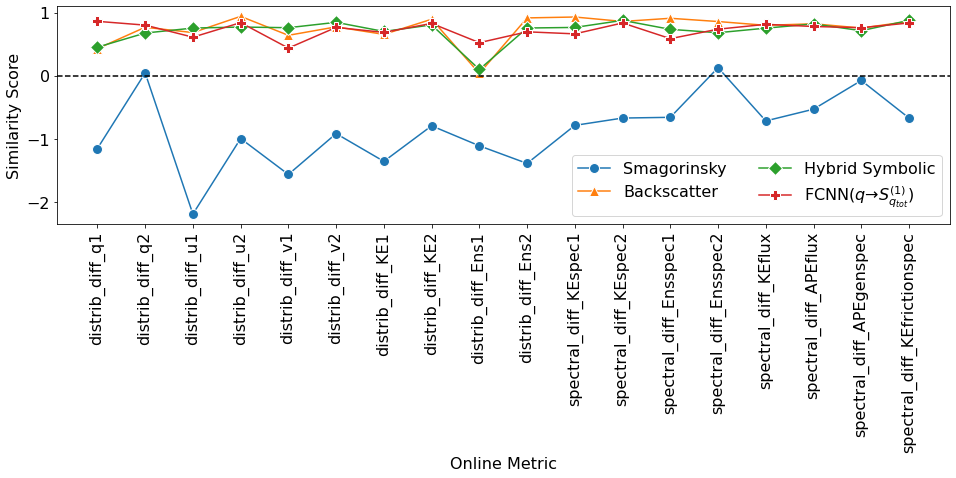

In [37]:
metrics = list(symb_sims.keys())
with plt.rc_context({'font.size': 16}):
    plt.figure(figsize=(16, 4))
    for sims, label, m in [(smag_sims,'Smagorinsky', 'o'),
                        (back_sims,'Backscatter', '^'),
                        (symb_sims,'Hybrid Symbolic', 'D'),
                        (fcnn_sims,r'FCNN($q \to S_{q_{tot}}^{(1)}$)','P')]:
        plt.plot([sims[k] for k in metrics], label=label,
                 marker=m, markeredgecolor='white', markersize=10)
    plt.legend(ncol=2)
    plt.axhline(0, ls='--', color='black')
    plt.xticks(np.arange(len(metrics)), metrics, rotation=90)
    plt.ylabel("Similarity Score")
    plt.xlabel("Online Metric")
    plt.show()

We can see that three of our four parameterizations are helping essentially across the board, though the FCNN is most consistent. Interestingly, neither the backscatter nor the hybrid symbolic model lessen distributional differences between the upper-layer enstrophy.

## Run a similar test, but on jet configuration

Let's do the same set of experiments, but with a different configuration of `pyqg`. See the [dataset description](./dataset_description.ipynb) for more details about these configurations.

In [12]:
highres_jet = get_dataset("jet/high_res").load()
lowres_jet = get_dataset("jet/low_res").load()

In [13]:
jet_config = {}
jet_config.update(**eddy_config)
jet_config['rek'] = lowres_jet.attrs['pyqg:rek']
jet_config['beta'] = lowres_jet.attrs['pyqg:beta']
jet_config['delta'] = lowres_jet.attrs['pyqg:delta']

In [14]:
smagorinsky_jet = Smagorinsky(0.15).run_online(**jet_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 1.80e-07, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 2.61e-06, CFL: 0.006
INFO: Step: 30000, Time: 1.08e+08, KE: 5.62e-05, CFL: 0.012
INFO: Step: 40000, Time: 1.44e+08, KE: 1.39e-04, CFL: 0.029
INFO: Step: 50000, Time: 1.80e+08, KE: 1.60e-04, CFL: 0.036
INFO: Step: 60000, Time: 2.16e+08, KE: 1.27e-04, CFL: 0.030
INFO: Step: 70000, Time: 2.52e+08, KE: 1.15e-04, CFL: 0.032
INFO: Step: 80000, Time: 2.88e+08, KE: 1.10e-04, CFL: 0.029


In [15]:
backscatter_jet = BackscatterBiharmonic(np.sqrt(0.007), 1.2).run_online(**jet_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 2.50e-07, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 2.10e-06, CFL: 0.006
INFO: Step: 30000, Time: 1.08e+08, KE: 4.44e-05, CFL: 0.011
INFO: Step: 40000, Time: 1.44e+08, KE: 2.32e-04, CFL: 0.038
INFO: Step: 50000, Time: 1.80e+08, KE: 1.85e-04, CFL: 0.039
INFO: Step: 60000, Time: 2.16e+08, KE: 1.79e-04, CFL: 0.045
INFO: Step: 70000, Time: 2.52e+08, KE: 1.96e-04, CFL: 0.039
INFO: Step: 80000, Time: 2.88e+08, KE: 1.80e-04, CFL: 0.039


In [16]:
hybrid_symbolic_jet = HybridSymbolic().run_online(**jet_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 3.03e-07, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 3.95e-06, CFL: 0.006
INFO: Step: 30000, Time: 1.08e+08, KE: 9.52e-05, CFL: 0.019
INFO: Step: 40000, Time: 1.44e+08, KE: 2.27e-04, CFL: 0.040
INFO: Step: 50000, Time: 1.80e+08, KE: 2.06e-04, CFL: 0.039
INFO: Step: 60000, Time: 2.16e+08, KE: 1.67e-04, CFL: 0.039
INFO: Step: 70000, Time: 2.52e+08, KE: 1.58e-04, CFL: 0.037
INFO: Step: 80000, Time: 2.88e+08, KE: 1.60e-04, CFL: 0.036


In [38]:
fcnn_jet = xr.open_dataset("../models/fcnn_q_to_Sqtot1/jet_run.nc")

In [17]:
smag_sims_jet = ppb.diagnostic_similarities(smagorinsky_jet, target=highres_jet, baseline=lowres_jet)
smag_sims_jet

{'distrib_diff_q1': -0.8441046221883806,
 'distrib_diff_q2': -0.12028116622070062,
 'distrib_diff_u1': -0.8934605167166185,
 'distrib_diff_u2': -1.5196326276753047,
 'distrib_diff_v1': -0.916758326744336,
 'distrib_diff_v2': -0.69392787276553,
 'distrib_diff_KE1': -0.5194406353732297,
 'distrib_diff_KE2': -0.7660377743039373,
 'distrib_diff_Ens1': -0.6042291741105765,
 'distrib_diff_Ens2': -0.7741303807475304,
 'spectral_diff_KEspec1': -0.41192246792282394,
 'spectral_diff_KEspec2': -0.028043794728699112,
 'spectral_diff_Ensspec1': -0.32501011358921517,
 'spectral_diff_Ensspec2': 0.033719594822898324,
 'spectral_diff_KEflux': -1.4796208458039364,
 'spectral_diff_APEflux': -0.29794185526697503,
 'spectral_diff_APEgenspec': -3.05433467527122,
 'spectral_diff_KEfrictionspec': -0.02804388278320258}

The Smagorinsky parameterization still gets negative similarity scores, though they aren't any _more_ negative than before.

In [18]:
back_sims_jet = ppb.diagnostic_similarities(backscatter_jet, target=highres_jet, baseline=lowres_jet)
back_sims_jet

{'distrib_diff_q1': 0.37867721033210966,
 'distrib_diff_q2': -0.24147720174967868,
 'distrib_diff_u1': 0.29595097309028373,
 'distrib_diff_u2': -0.3578784252441518,
 'distrib_diff_v1': 0.24798558006636628,
 'distrib_diff_v2': 0.6536339405264385,
 'distrib_diff_KE1': 0.3272689039838843,
 'distrib_diff_KE2': 0.7670655540422876,
 'distrib_diff_Ens1': -0.027261258726249515,
 'distrib_diff_Ens2': 0.8415810849609231,
 'spectral_diff_KEspec1': 0.5054921365358627,
 'spectral_diff_KEspec2': 0.6304967828557736,
 'spectral_diff_Ensspec1': 0.3890747054485162,
 'spectral_diff_Ensspec2': -1.6689963378822394,
 'spectral_diff_KEflux': -0.3294650315596026,
 'spectral_diff_APEflux': 0.14854163296578038,
 'spectral_diff_APEgenspec': -1.4263009731826166,
 'spectral_diff_KEfrictionspec': 0.6304965999952614}

The backscatter model gets marginally positive similarity scores in this case (it's not super consistent across re-runs), though it also has a number of fairly negative scores. Overall, it's not generalizing exactly the way we would hope. 

In [19]:
symb_sims_jet = ppb.diagnostic_similarities(hybrid_symbolic_jet, target=highres_jet, baseline=lowres_jet)
symb_sims_jet

{'distrib_diff_q1': 0.3013357118582074,
 'distrib_diff_q2': 0.8302586893435769,
 'distrib_diff_u1': 0.09539551481215547,
 'distrib_diff_u2': 0.6351608846232737,
 'distrib_diff_v1': 0.21042497458981113,
 'distrib_diff_v2': 0.33641830804437056,
 'distrib_diff_KE1': 0.19187099157476306,
 'distrib_diff_KE2': 0.45323763465048406,
 'distrib_diff_Ens1': 0.008931718246745879,
 'distrib_diff_Ens2': 0.2787261833450858,
 'spectral_diff_KEspec1': 0.7327749047623282,
 'spectral_diff_KEspec2': 0.743159276560581,
 'spectral_diff_Ensspec1': 0.7472454929987318,
 'spectral_diff_Ensspec2': 0.4341378412636606,
 'spectral_diff_KEflux': 0.5116536666971608,
 'spectral_diff_APEflux': 0.3053027457363845,
 'spectral_diff_APEgenspec': -0.23880148223531794,
 'spectral_diff_KEfrictionspec': 0.7431593768535658}

The symbolic regression model has much more consistently positive scores, indicating better generalization ability!

In [39]:
fcnn_sims_jet = ppb.diagnostic_similarities(fcnn_jet, target=highres_jet, baseline=lowres_jet)
fcnn_sims_jet

{'distrib_diff_q1': -0.8588529704019516,
 'distrib_diff_q2': -6.076960113285655,
 'distrib_diff_u1': -1.1048739003828176,
 'distrib_diff_u2': -5.117374046261305,
 'distrib_diff_v1': -0.9087414290907698,
 'distrib_diff_v2': -1.1243769963964567,
 'distrib_diff_KE1': -0.45227928917742366,
 'distrib_diff_KE2': -3.773582181274306,
 'distrib_diff_Ens1': 0.7275194890939172,
 'distrib_diff_Ens2': -1.3458529447075827,
 'spectral_diff_KEspec1': -1.9000374017403678,
 'spectral_diff_KEspec2': -6.116048984619001,
 'spectral_diff_Ensspec1': -4.519555052821196,
 'spectral_diff_Ensspec2': -34.429454116657,
 'spectral_diff_KEflux': -6.638731873889921,
 'spectral_diff_APEflux': -5.687623651463459,
 'spectral_diff_APEgenspec': -3.1477373436622864,
 'spectral_diff_KEfrictionspec': -6.116051753879307}

The neural network gets very negative similarity scores, indicating that it's not succeeding in transferring. The lower-layer enstrophy in particular gets a similarity score of -34. When plotting, we'll need to manually set the $y$ limits, or else the plot will be unreadable:

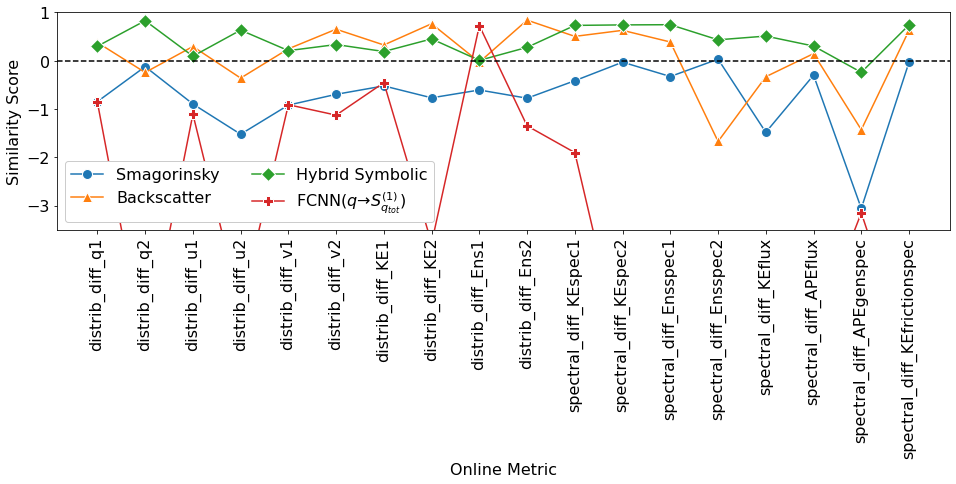

In [42]:
metrics = list(symb_sims.keys())
with plt.rc_context({'font.size': 16}):
    plt.figure(figsize=(16, 4))
    for sims, label, m in [(smag_sims_jet,'Smagorinsky', 'o'),
                        (back_sims_jet,'Backscatter', '^'),
                        (symb_sims_jet,'Hybrid Symbolic', 'D'),
                        (fcnn_sims_jet,r'FCNN($q \to S_{q_{tot}}^{(1)}$)','P')]:
        plt.plot([sims[k] for k in metrics], label=label,
                 marker=m, markeredgecolor='white', markersize=10)
    plt.legend(ncol=2, framealpha=1)
    plt.axhline(0, ls='--', color='black')
    plt.xticks(np.arange(len(metrics)), metrics, rotation=90)
    plt.ylabel("Similarity Score")
    plt.xlabel("Online Metric")
    plt.ylim(-3.5,1)
    plt.show()

The symbolic regression model does best by most of the metrics, though the backscatter model does well on many, and interestingly the FCNN does get closest on the upper-layer enstrophy again. This is consistent with a result we see in [the FCNN notebook](./neural_networks.ipynb), where its upper-layer $R^2$s remain high when transferring to jet configuration while its lower-layer $R^2$s plummet.

Note that there is some degree of variance to these results, so in the paper we average over ensembles of multiple runs.